In [2]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
print("Done!")
import sys
sys.path.append("..")
import keras
from keras.datasets import cifar10
print("Done!")

Done!


/home/beren/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done!


In [3]:
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()
print(xtrain.shape)

(50000, 32, 32, 3)


In [4]:
# okay... so now grayscale
"""
plt.imshow(xtrain[0])
plt.show()
d = utils.rgb2gray(xtrain[0])
plt.imshow(d, cmap='gray')
plt.show()
plt.imshow(xtrain[0][:,:,0], cmap='gray')
plt.show()
# so there is slighty differences but the second one is better, so I will utilize that
"""

print(32*32)
data = []
for d in xtrain:
    d = utils.rgb2gray(d)
    d = d / 255.
    d = utils.flatten(d)
    d = np.reshape(d, (1024,1))
    data.append(d)
data = np.array(data)
print(data.shape)


1024
(50000, 1024, 1)


In [5]:
class Model():
    
    def __init__(self, data, epochs, convergence_runs=200):
        self.convergence_runs = 200
        self.data = data
        self.epochs = epochs
        self.layers = []
        self.upwards = []
        self.downwards = []
        self.wlist = []
        self.predlist = []
        self.pelist = []
        self.full_predlist = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def initialize(self):
        for i, layer in enumerate(self.layers):
            self.upwards.append(np.random.normal(0,0.1, [layer.top_down_size,1]))
            self.downwards.append(np.random.normal(0,0.1, [layer.bottom_up_size,1]))
            self.wlist.append([])
            self.predlist.append([])
            self.pelist.append([])
        self.upwards.append(0)
        self.downwards.append(None)
            
    def train(self):
        for epoch in range(self.epochs):
            print("Starting epoch: " + str(epoch))
            self.downwards[-1] = None
            for dat in self.data:
                self.upwards[0] = np.reshape(dat,(len(dat),1)) 
                for i in range(self.convergence_runs):
                    for j,layer in enumerate(self.layers):
                        up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1])
                        self.upwards[j+1] = up
                        self.downwards[j] = down
                        self.wlist[j].append(np.sum(weights))
                        self.predlist[j].append(np.sum(preds))
                        self.pelist[j].append(np.sum(pes))
                        
            self.full_predlist.append(np.copy(self.layers[0].preds))
            
            
    def get_latents(self, inputs):
        latents = []
        for inp in inputs:
            for i in range(self.convergence_runs):
                self.upwards[0] = np.reshape(inp, (len(inp),1))
                for j,layer in enumerate(self.layers):
                    #print("Layer : " + str(j))
                    up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1], training=False) # as only inference!
                    self.upwards[j+1] = up
                    self.downwards[j] = down 
            latents.append(np.copy(self.layers[-1].latents)) 
        return latents
    
    def get_predictions_from_latents(self, latents):
        predictions = []
        for l in latents:
            l1 = self.layers[0]
            pred = l1.top_down_prediction(l1.weights, l)
            predictions.append(pred)
            
        return predictions
    
    def get_predictions_from_data(self,data, plot=True):
        latents = self.get_latents(data)
        preds = self.get_predictions_from_latents(latents)
        if plot:
            for dat, pred in zip(data, preds):
                plt.imshow(np.reshape(dat, (32,32)))
                plt.show()
                plt.imshow(np.reshape(dat, (32,32)))
                plt.show()
        return preds
    
    def interpolation_latents(self,l1, l2, num_steps):
        interps = []
        diff = (l2 - l1) / num_steps
        for i in range(num_steps):
            latent = l1 + (i * diff)
            for i in range(self.convergence_runs):
                self.upwards[0] = np.reshape(latent, (len(latent),1))
                for j,layer in enumerate(self.layers):
                    #print("Layer : " + str(j))
                    up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1], training=False) # as only inference!
                    self.upwards[j+1] = up
                    self.downwards[j] = down 
            interps.append(np.copy(self.layers[-1].latents)) 
        return interps

    def interpolate(self, l1, l2,num_steps, plot=True):
        interps = self.interpolation_latents(l1, l2, num_steps)
        preds = self.get_predictions_from_latents(interps)
        if plot:
            sh = int(np.sqrt(len(preds[0])))
            for pred in preds:
                plt.imshow(np.reshape(pred, (sh,sh)), cmap='gray')
                plt.show()
                
        return preds
                        
    def plot(self):
        self.wlist = np.array(self.wlist[0])
        self.predlist = np.array(self.predlist[0])
        self.pelist = np.array(self.pelist[0])
        plt.plot(self.wlist)
        plt.show()
        plt.plot(self.predlist)
        plt.show()
        plt.plot(self.pelist)
        plt.show()
        for pred in self.full_predlist:
            plt.imshow(np.reshape(pred, (int(np.sqrt(len(pred))), int(np.sqrt(len(pred))))), cmap='gray')
            plt.show()  

class Layer():
    
    def __init__(self,learning_rate, bottom_up_size, top_down_size, input_layer=False, weight_update_ratio = 1):
        self.learning_rate = learning_rate
        self.bottom_up_size = bottom_up_size
        self.top_down_size = top_down_size
        self.weights = np.random.normal(0, 0.1, [bottom_up_size, top_down_size])
        self.latents = np.random.normal(0, 0.1, [bottom_up_size,1])
        self.input_layer = input_layer
        self.weight_update_ratio = weight_update_ratio
               
        
    def upward_projection(self,pe, w):
        return np.dot(w.T, pe)

    def update_weight(self,pe, u):
        return learning_rate * np.dot(pe, u.T)

    def update_cause_unit(self,bu , pe):
        return learning_rate * np.subtract(bu, pe)

    def top_down_prediction(self,w, td):
        return np.dot(w, td)

    def prediction_error(self,u, pred):
        return np.subtract(u, pred)
    
    
    def run(self, bottom_up, top_down, training=True):
        if self.input_layer:
            self.latents = bottom_up
        if top_down is None:
            pe1 = self.prediction_error(self.latents, 0)
            self.latents += self.update_cause_unit(bottom_up, pe1)
            self.preds = pe1
            return None, self.latents, self.weights, pe1, pe1
        else:
            self.preds = self.top_down_prediction(self.weights, top_down)
            pe1 = self.prediction_error(self.latents, self.preds)            
            up = self.upward_projection(pe1, self.weights)
            #print(np.sum(pred))
            #print(np.sum(pe1))
            #print(np.sum(up))
            if not self.input_layer:
                self.latents += self.update_cause_unit(bottom_up, pe1)
            if i % weight_update_ratio == 0 and training is True:
                self.weights += self.update_weight(pe1, top_down)
            
            return up, self.latents, self.weights, self.preds, pe1
        
print("Done!")

Done!


Starting epoch: 0
Starting epoch: 1
Starting epoch: 2
Starting epoch: 3
Starting epoch: 4
Starting epoch: 5
Starting epoch: 6
Starting epoch: 7
Starting epoch: 8
Starting epoch: 9


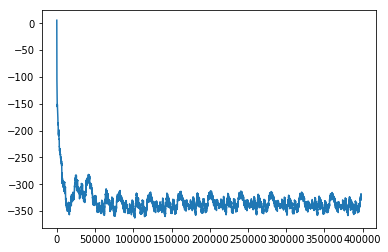

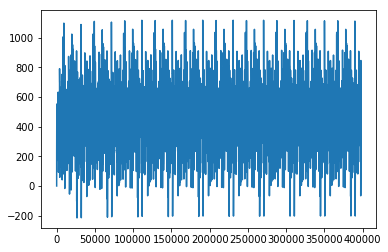

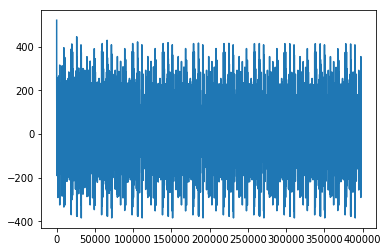

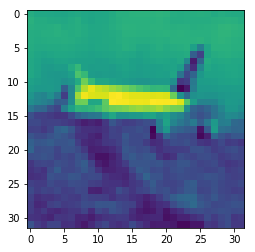

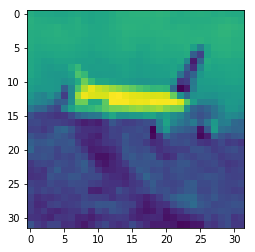

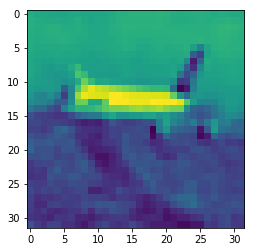

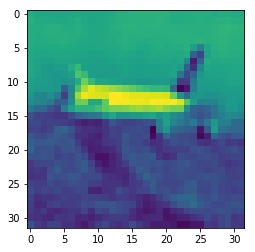

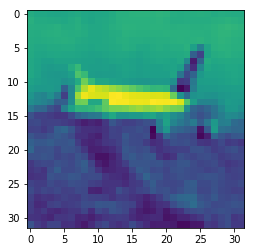

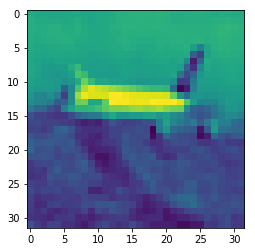

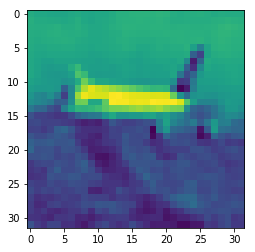

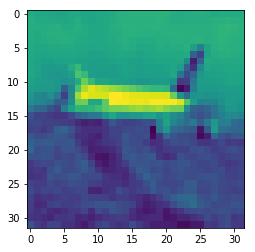

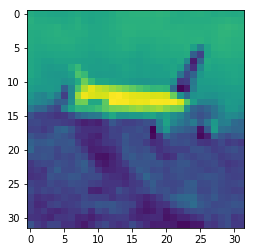

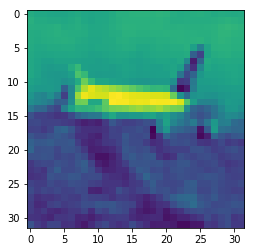

In [6]:
learning_rate = 0.01
i = 4
weight_update_ratio = 1
m = Model(data[1:200], 10)
l1 = Layer(0.01, 1024, 50, input_layer=True)
l2 = Layer(0.01, 50,1)
m.add(l1)
m.add(l2)
m.initialize()
m.train()
m.plot()

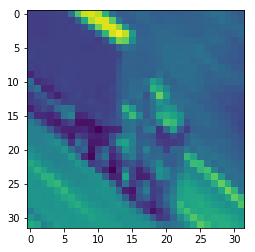

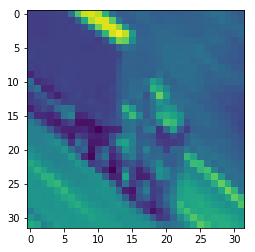

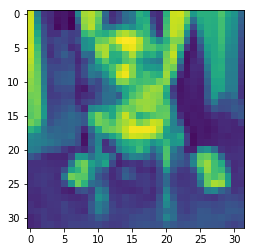

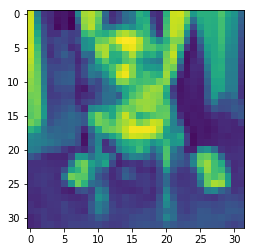

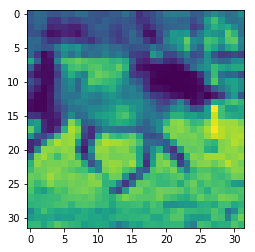

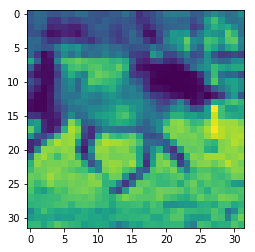

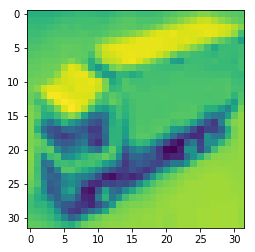

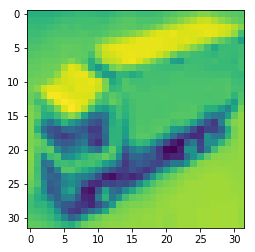

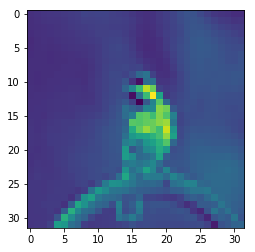

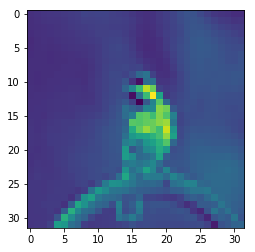

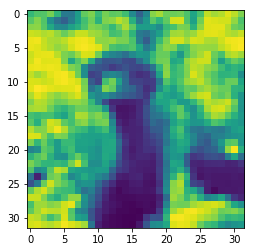

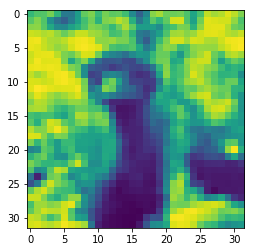

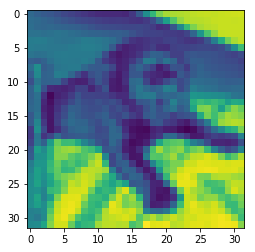

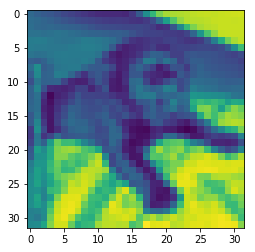

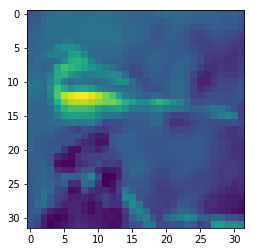

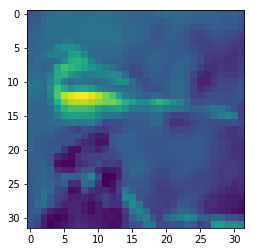

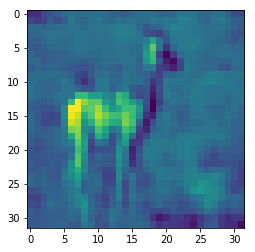

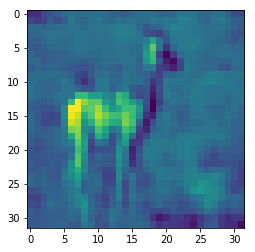

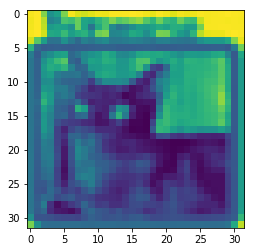

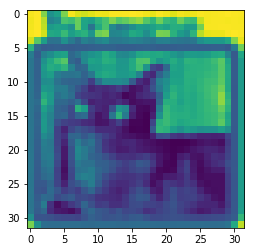

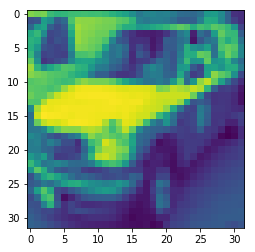

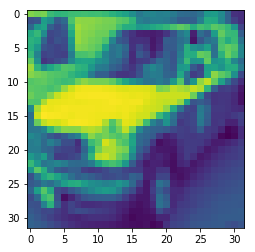

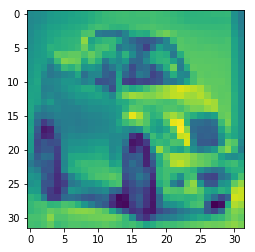

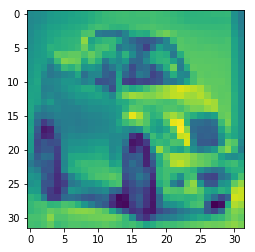

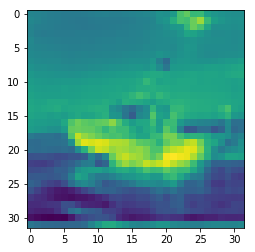

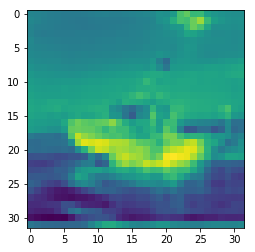

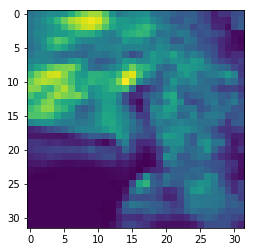

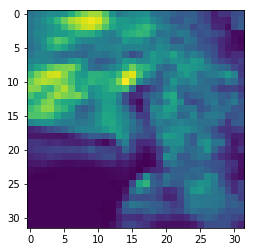

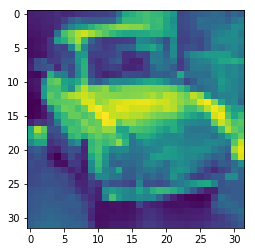

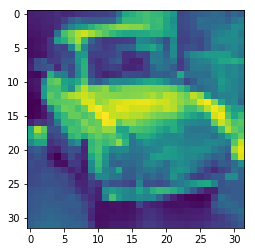

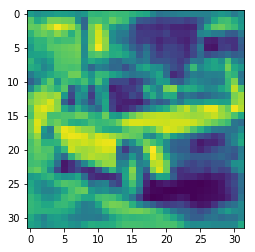

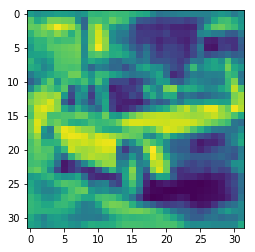

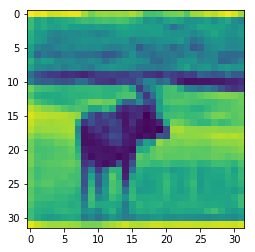

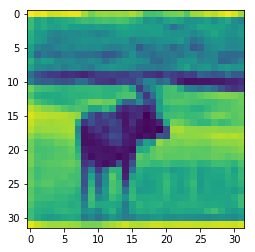

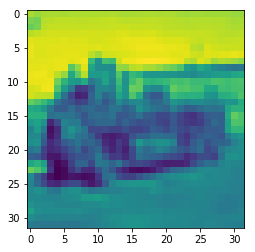

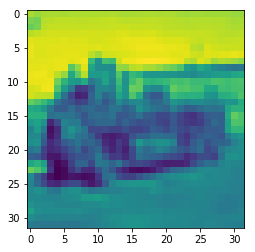

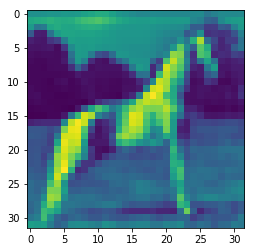

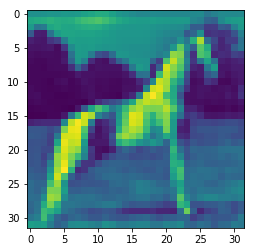

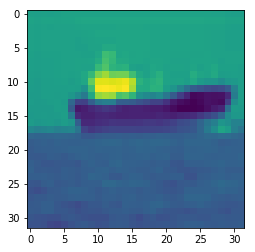

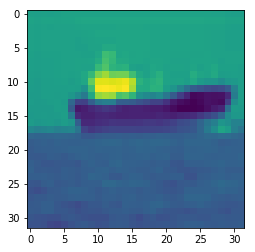

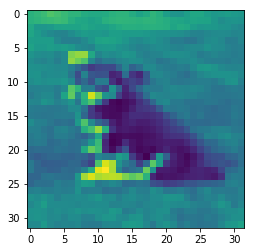

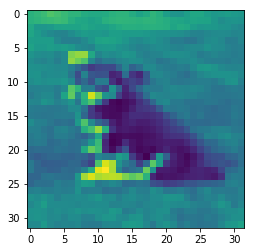

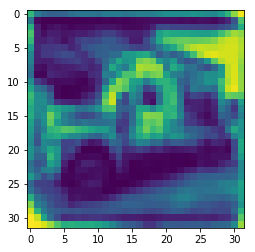

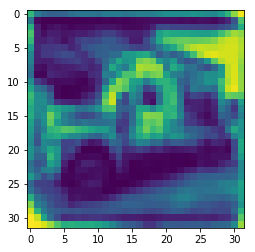

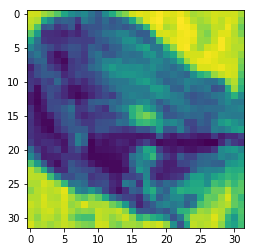

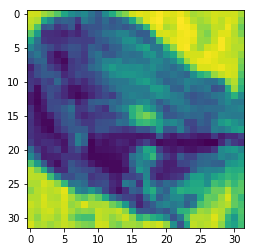

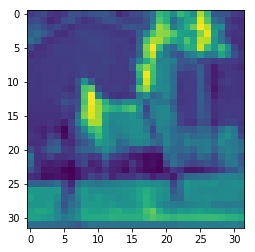

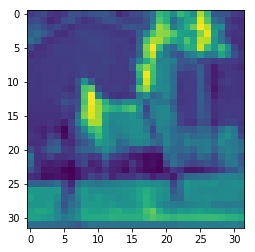

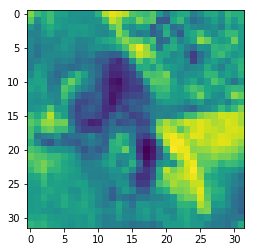

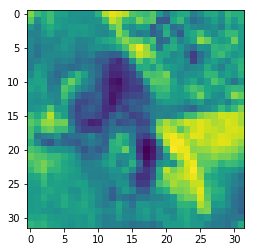

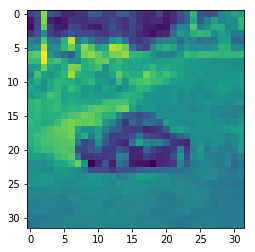

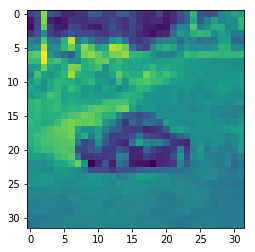

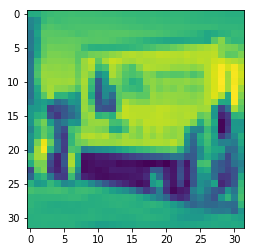

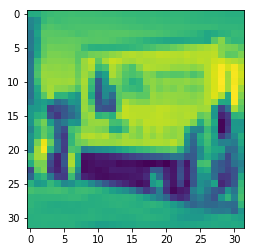

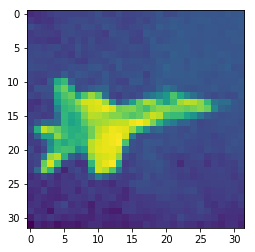

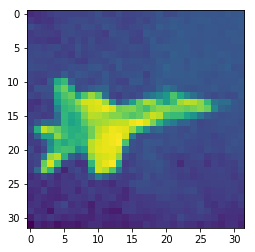

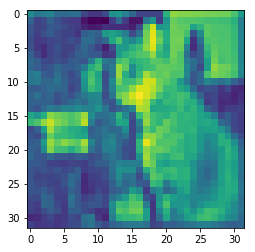

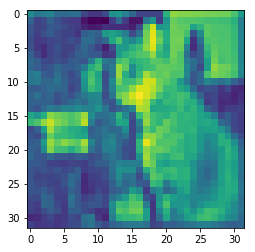

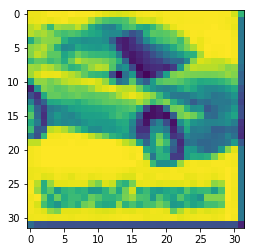

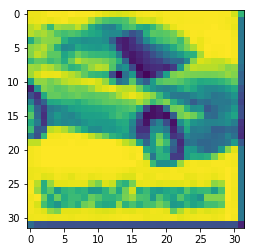

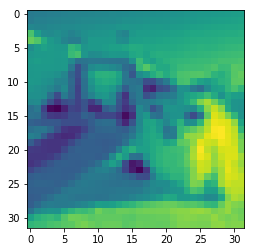

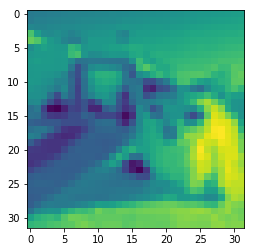

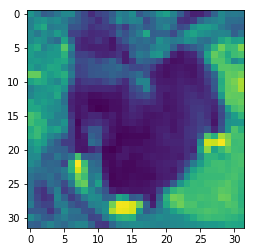

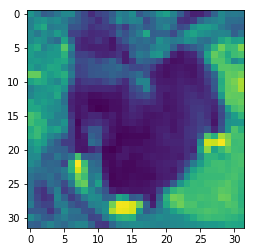

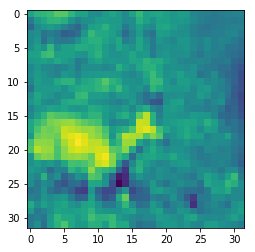

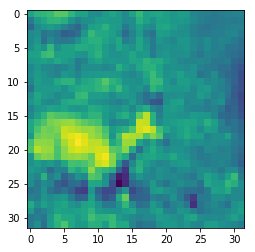

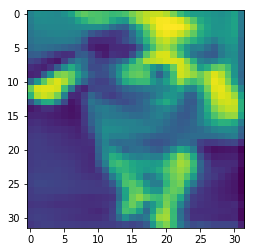

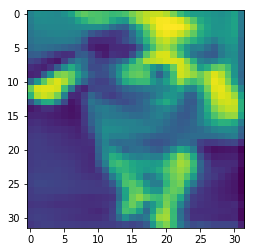

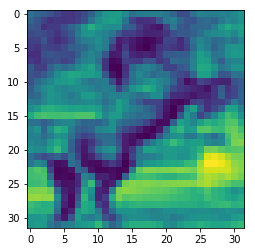

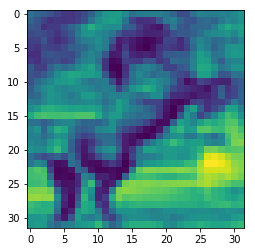

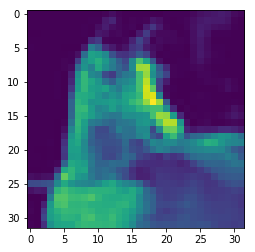

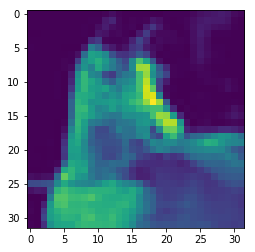

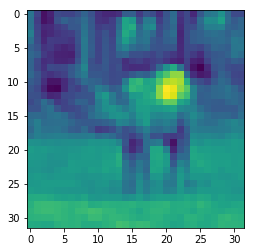

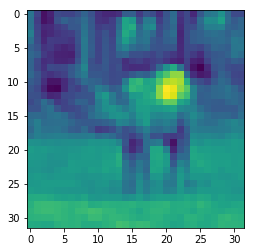

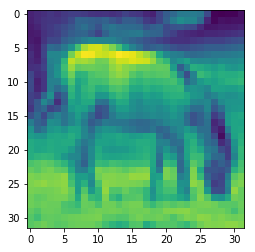

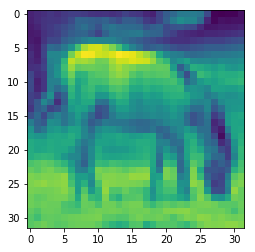

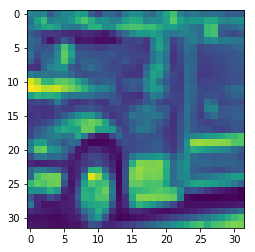

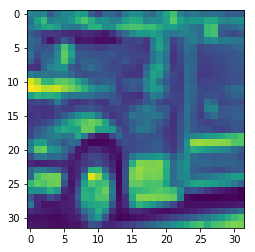

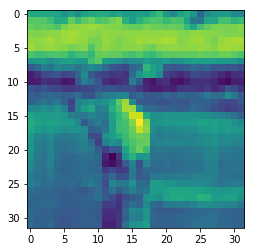

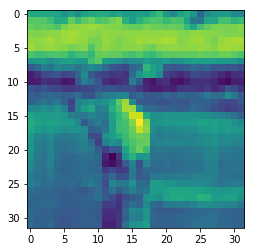

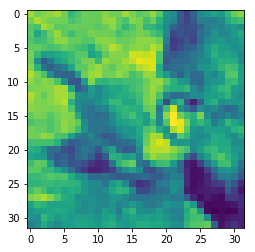

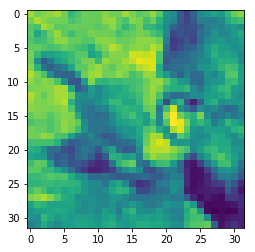

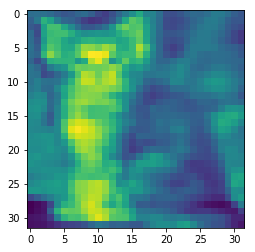

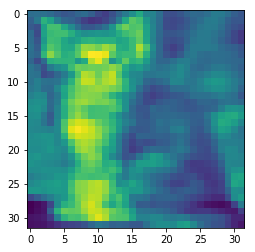

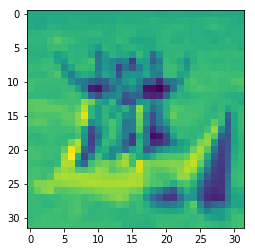

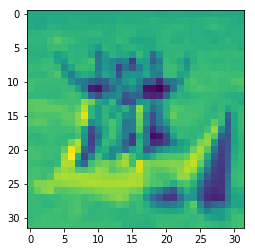

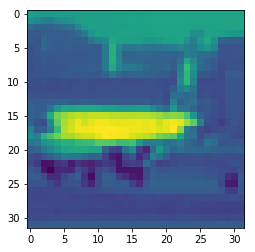

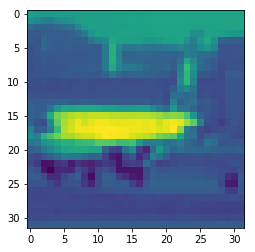

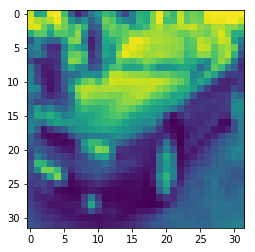

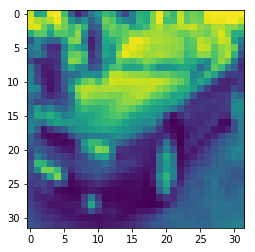

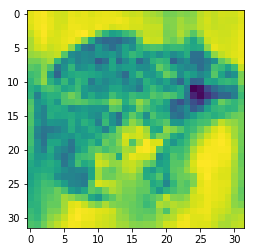

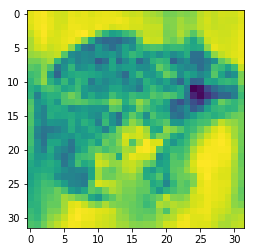

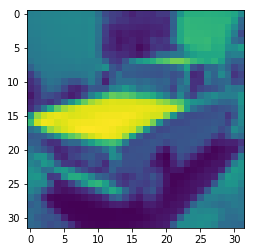

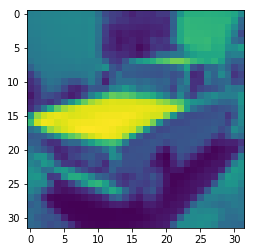

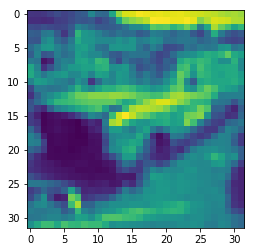

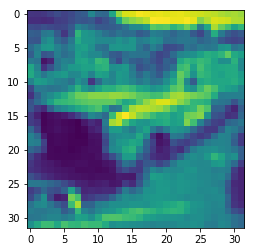

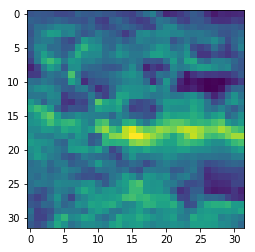

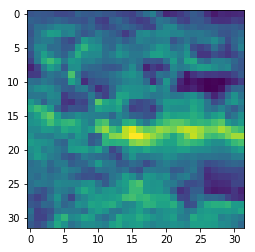

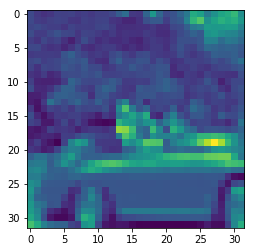

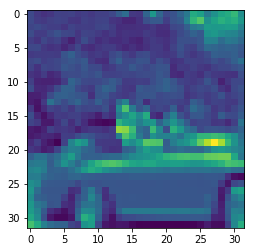

In [98]:
preds = m.get_predictions_from_data(data[50:100])


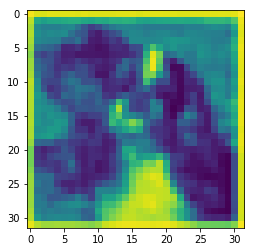

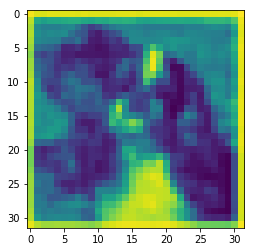

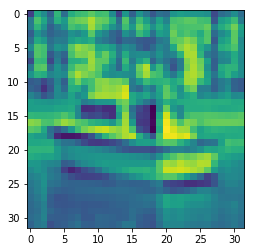

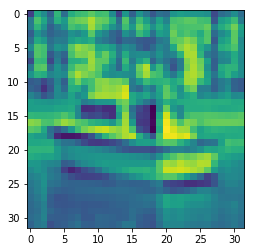

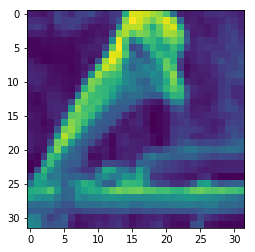

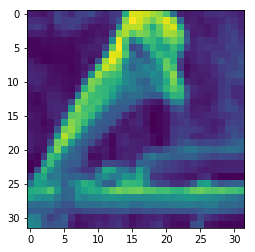

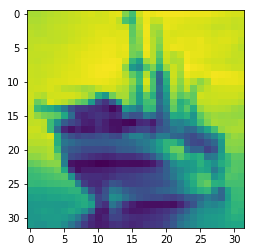

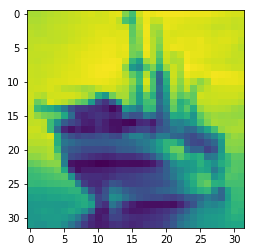

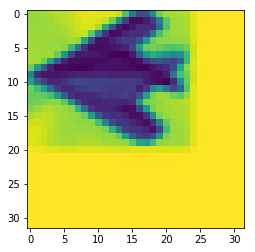

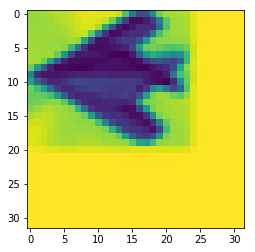

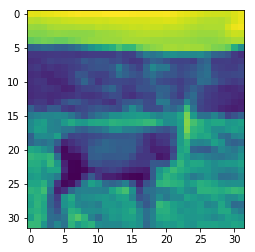

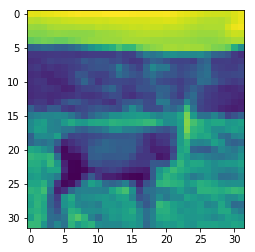

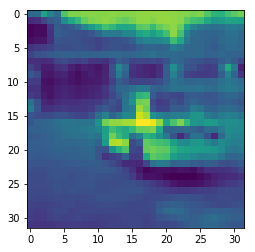

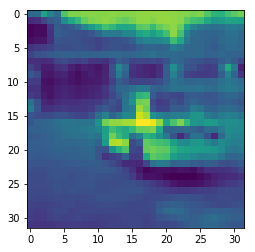

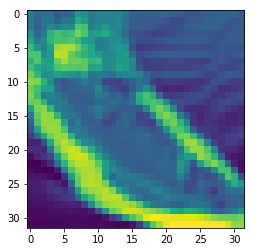

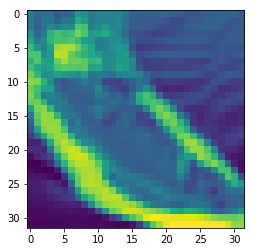

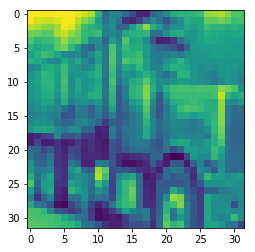

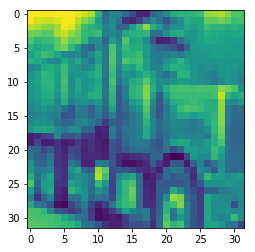

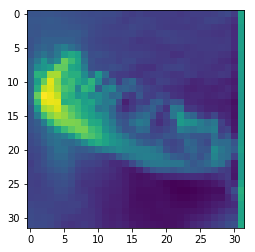

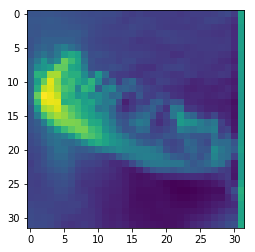

In [11]:
preds = m.get_predictions_from_data(data[500:510])

(1024, 50)


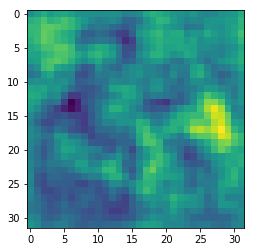

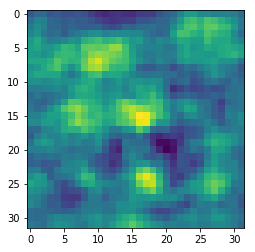

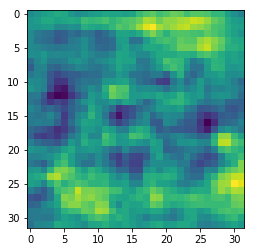

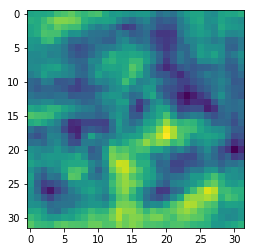

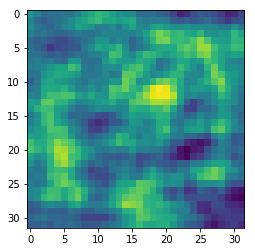

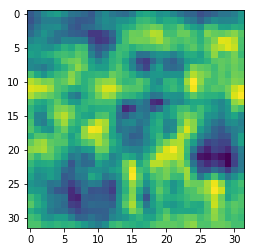

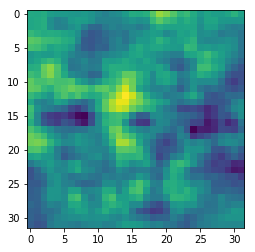

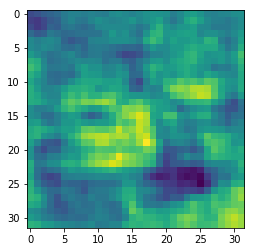

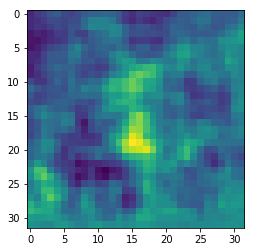

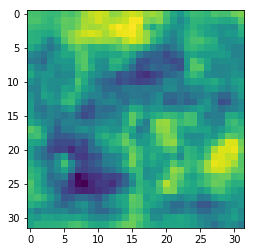

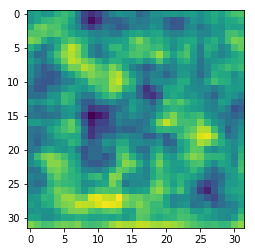

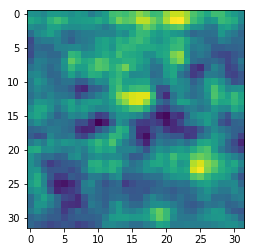

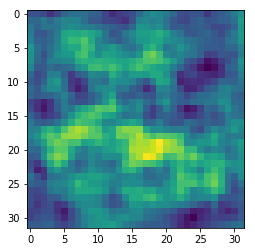

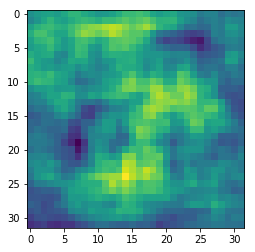

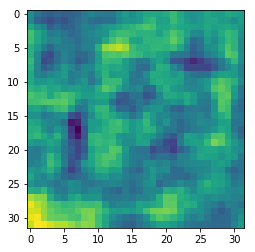

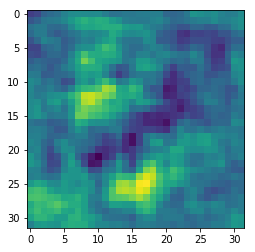

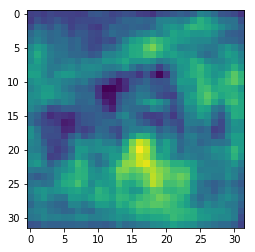

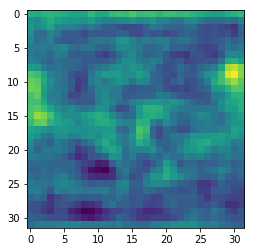

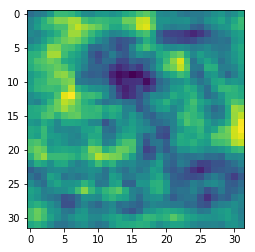

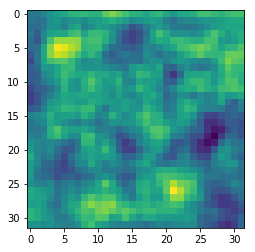

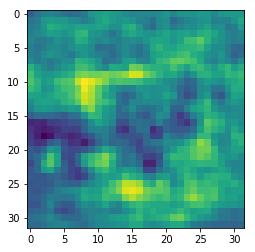

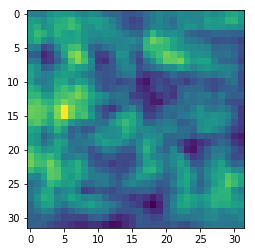

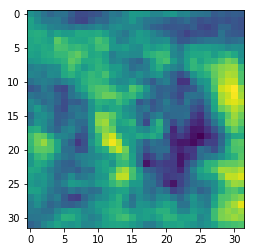

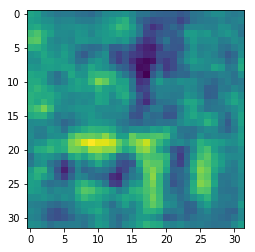

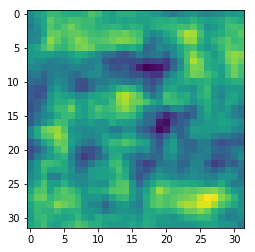

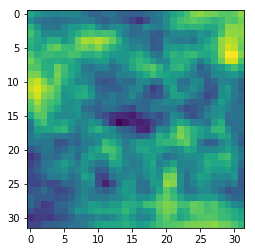

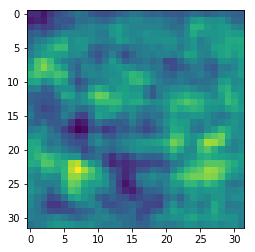

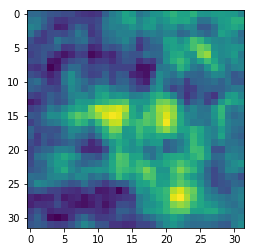

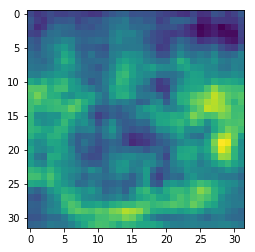

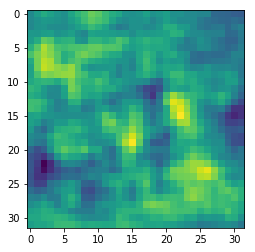

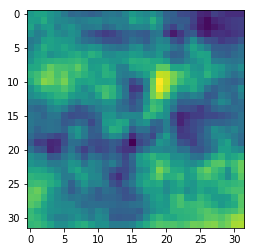

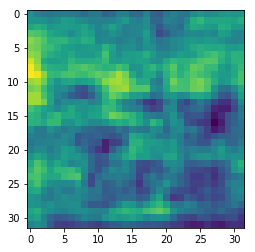

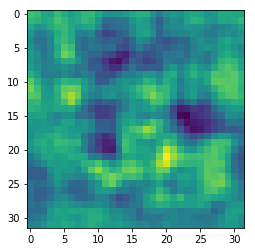

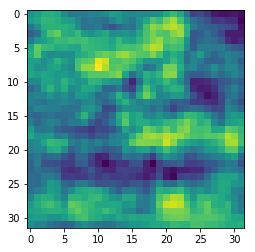

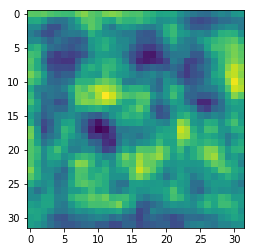

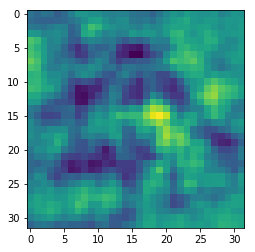

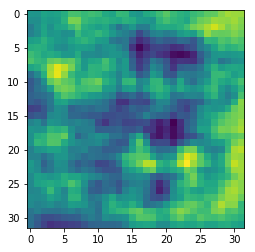

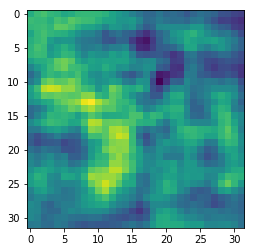

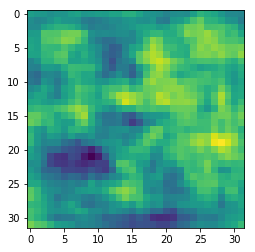

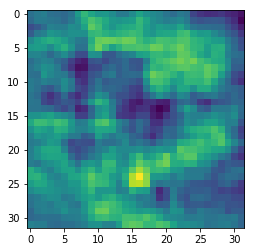

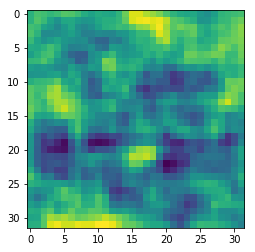

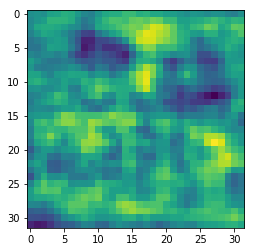

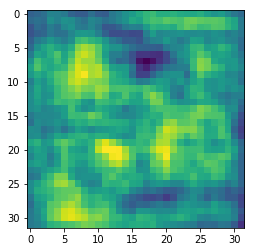

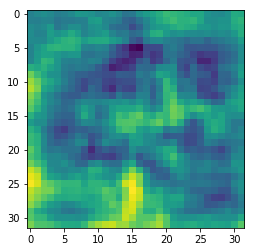

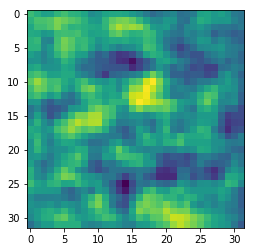

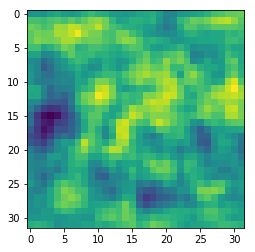

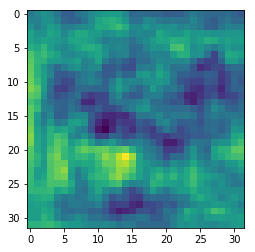

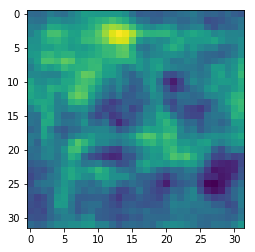

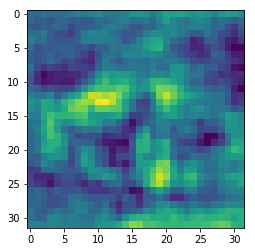

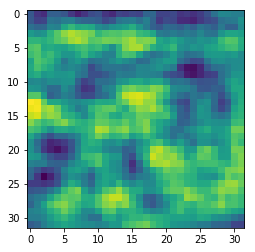

In [99]:
ws = m.layers[0].weights
print(ws.shape)
for i in range(ws.shape[1]):
    plt.imshow(np.reshape(ws[:,i], (32,32)))
    plt.show()

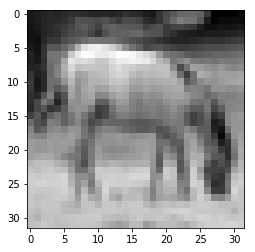

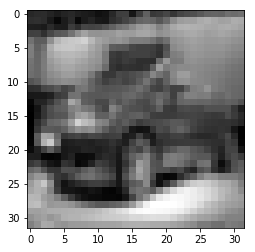

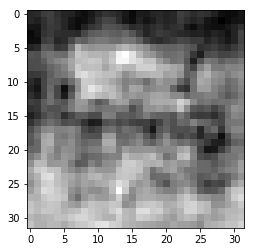

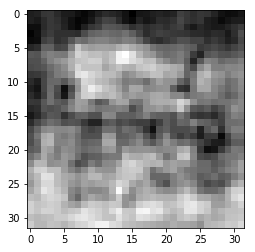

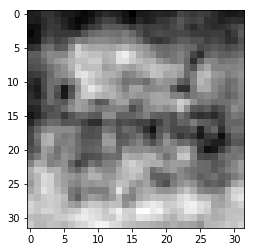

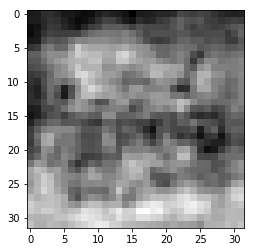

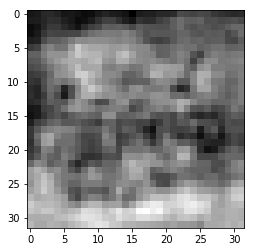

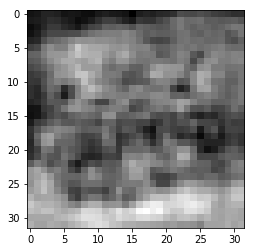

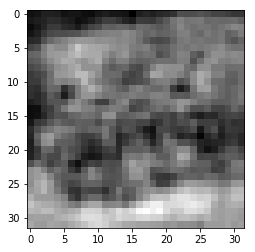

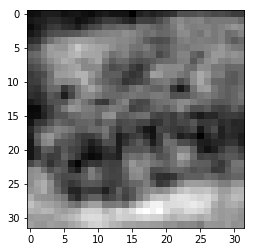

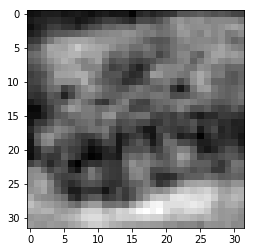

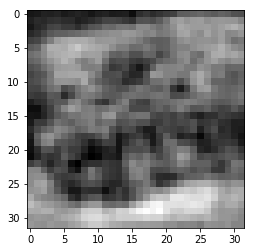

In [104]:
d1 = data[87]
d2 = data[45]
plt.imshow(np.reshape(d1, (32,32)), cmap='gray')
plt.show()
plt.imshow(np.reshape(d2, (32,32)), cmap='gray')
plt.show()


preds = m.interpolate(d1, d2,10)

In [10]:
preds = m.interpolate(data[7], data[9],1000, plot=False)
print("Interpolated")
ls = []
for p in preds:
    ls.append(np.reshape(p, (32,32)))
ls = np.array(ls)
np.save("Cifar_horse_cat_interpolation_frames.npy",ls)
print("Saved!")

Interpolated
Saved!


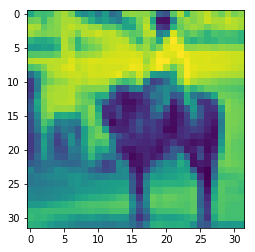

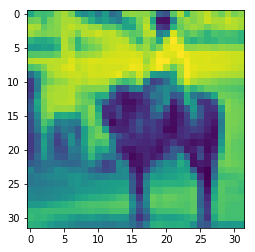

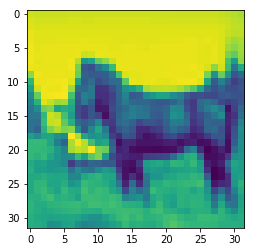

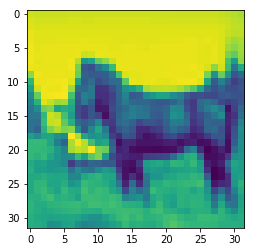

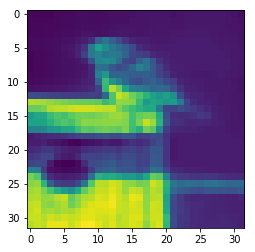

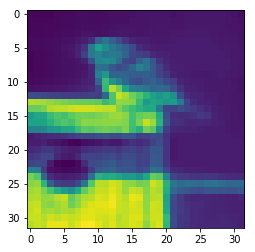

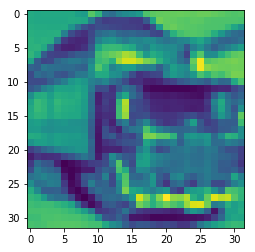

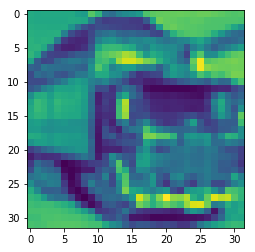

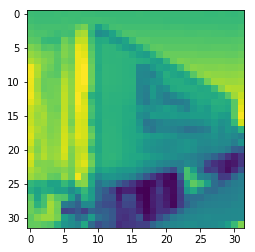

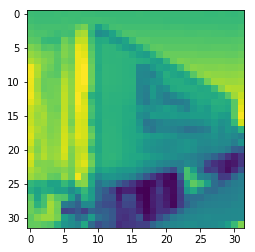

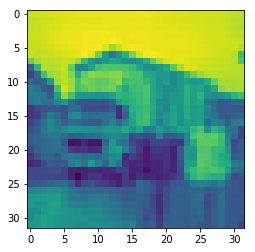

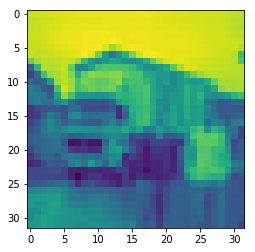

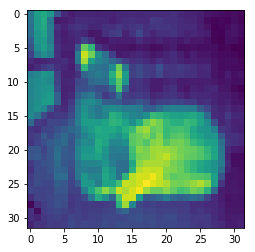

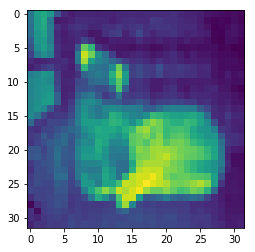

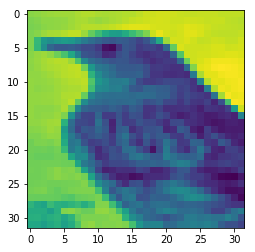

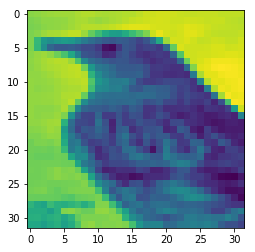

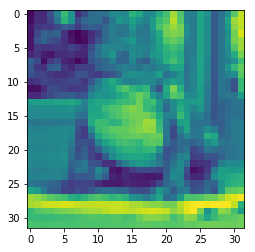

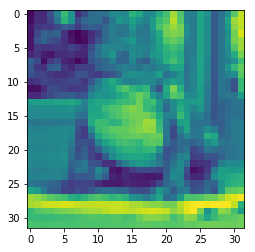

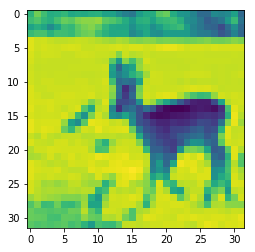

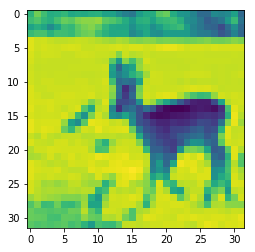

In [56]:
preds = m.get_predictions_from_data(data[11:21])


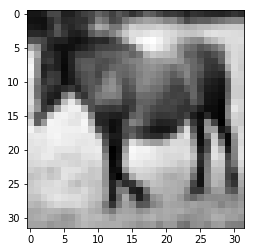

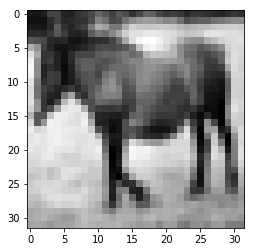

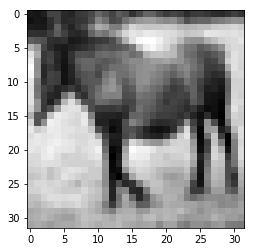

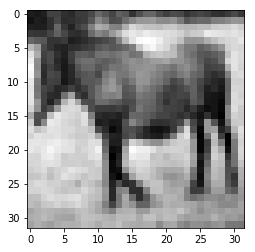

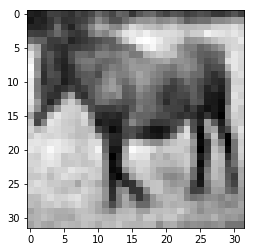

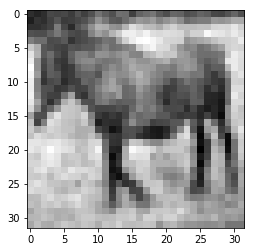

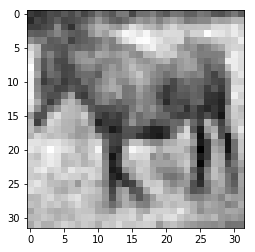

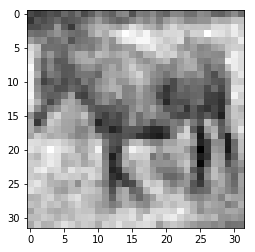

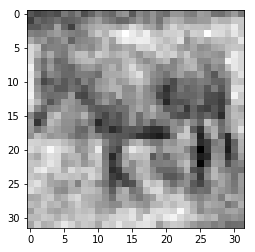

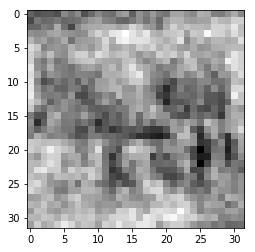

In [63]:
preds = m.interpolate(data[7], data[45], 10) 

(50,)
(1024,)


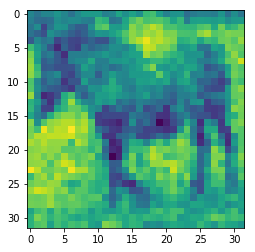

(1024,)


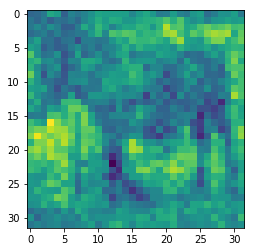

(1024,)


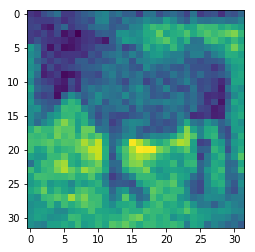

(1024,)


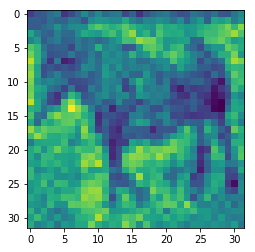

(1024,)


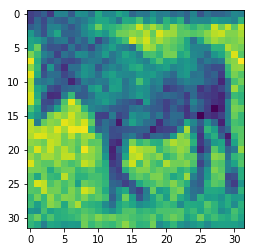

(1024,)


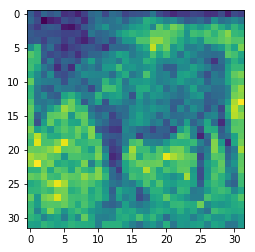

(1024,)


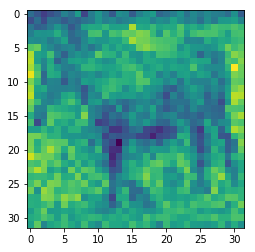

(1024,)


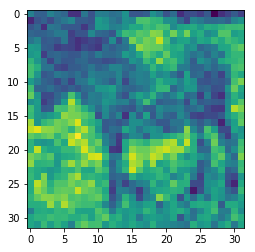

(1024,)


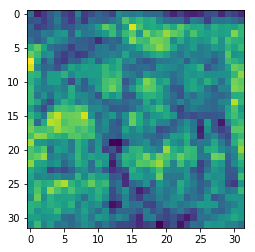

(1024,)


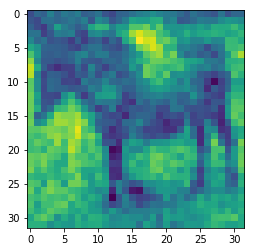

In [96]:
latent = m.get_latents(data[7:8])
latent = np.reshape(latent[0], (50,))
print(latent.shape)
latents = []
for i in range(10):
    latents.append(latent + np.random.normal(0, 20 * np.mean(latent), len(latent)))
preds = m.get_predictions_from_latents(latents)
for pred in preds:
    print(pred.shape)
    plt.imshow(np.reshape(pred, (32,32)))
    plt.show()
    


In [88]:
r = np.random.normal(0, 10*np.mean(latent[0]), len(latent[0]))
print(r.shape)
print(latent)
print(latent + r)

(50,)
[array([[-0.39972739],
       [ 0.24273237],
       [ 0.39852071],
       [-0.13867529],
       [ 0.45527185],
       [ 0.15398621],
       [ 0.00290639],
       [ 0.2185188 ],
       [ 0.03361389],
       [ 0.20212832],
       [-0.02701512],
       [ 0.08313374],
       [ 0.00497581],
       [-0.29073925],
       [ 0.28338702],
       [ 0.1043168 ],
       [-0.06518655],
       [-0.03358704],
       [-0.16918709],
       [-0.07815774],
       [-0.0020403 ],
       [-0.09514912],
       [-0.15447303],
       [-0.41653862],
       [ 0.3797674 ],
       [ 0.15502595],
       [-0.05808875],
       [-0.02675569],
       [ 0.0422382 ],
       [ 0.36844379],
       [ 0.23761806],
       [-0.11029064],
       [-0.25988531],
       [-0.27295204],
       [ 0.05536119],
       [ 0.05013139],
       [-0.19105909],
       [-0.00738334],
       [ 0.04721821],
       [ 0.00075726],
       [-0.16649352],
       [ 0.28768483],
       [ 0.21780624],
       [ 0.01467508],
       [ 0.09169081],
   